In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
import pickle as pkl
from typing import List
from functools import partial

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange

from mtt.models import load_model
from mtt.data import vector_to_image, stack_images, simulation_window, VectorData
from mtt.peaks import find_peaks
from mtt.utils import compute_ospa_components, compute_ospa

rng = np.random.default_rng()
sns.set_theme(
    context="paper",
    style="whitegrid",
    rc={
        "figure.figsize": (3.5, 3.5),
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
    },
)


In [59]:
scale = 1
simulation_idx = 40

with open(f"../data/test/{scale}km/simulations.pkl", "rb") as f:
    dataset_vectors: List[List[VectorData]] = pkl.load(f)


images = map(
    partial(vector_to_image, img_size=128 * scale), dataset_vectors[simulation_idx]
)
stacked = simulation_window(stack_images(images))


In [60]:
# find all simulations where the sensor is within the simulation window
for i, simulation_vectors in enumerate(dataset_vectors):
    vectors = simulation_vectors[0]
    sensors_within_window = np.all(
        np.abs(vectors.sensor_positions)
        <= np.array([vectors.simulator.window_width / 2] * 2),
        axis=1,
    )
    if sensors_within_window.sum() > 2:
        print(i)


40


In [61]:
cardinality = []
for simulation in dataset_vectors:
    cardinality.append([])
    for step in simulation:
        cardinality[-1].append(len(step.target_positions))


In [62]:
simulator = dataset_vectors[0][0].simulator
window = simulator.window_width
extent = [-window / 2, window / 2, -window / 2, window / 2]
n_detections = (
    simulator.n_sensors * np.pi * simulator.sensors[0].range_max ** 2 / 1000**2
)


In [63]:
# Make CNN Predictions
# model, name = load_model("../models/58c6fd8a.ckpt")
# model, name = load_model("wandb://damowerko/mtt/4uc51x21")
# model, name = load_model("wandb://damowerko/mtt/rmwq3ref")
# model, name = load_model("wandb://damowerko/mtt/eiytli6p")
model, name = load_model("wandb://damowerko/mtt/e7ivqipk")
model = model.cuda()


wandb: Downloading large artifact model-e7ivqipk:best_k, 102.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


In [64]:
filt_idx = -1
method = "kmeans"
n_peaks_scale = 1.0

with torch.no_grad():
    x = torch.stack([d.sensor_images for d in stacked], dim=0)
    output_images = model(x.cuda())
    pred_img = output_images.clamp(min=0).cpu().numpy() * n_peaks_scale

n = pred_img.shape[0]
width = simulator.simulation_width
window = simulator.window_width
extent = [-window / 2, window / 2, -window / 2, window / 2]

predictions_cnn = []
for i in trange(n):
    predictions_cnn.append(
        find_peaks(pred_img[i][filt_idx], width=window, method=method).means
    )

cardinality_cnn = pred_img.sum(axis=(-1, -2)).mean().item()
print(f"Mean cardinality estimate: {cardinality_cnn:.2f}")
cardinality_truth = np.mean(
    [len(d.info[filt_idx]["target_positions"]) for d in stacked]
)
print(f"Mean cardinality truth: {cardinality_truth}")
print(f"Ratio {cardinality_truth / cardinality_cnn:.2f}")


100%|██████████| 100/100 [00:01<00:00, 76.25it/s]

Mean cardinality estimate: 9.14
Mean cardinality truth: 7.57
Ratio 0.83


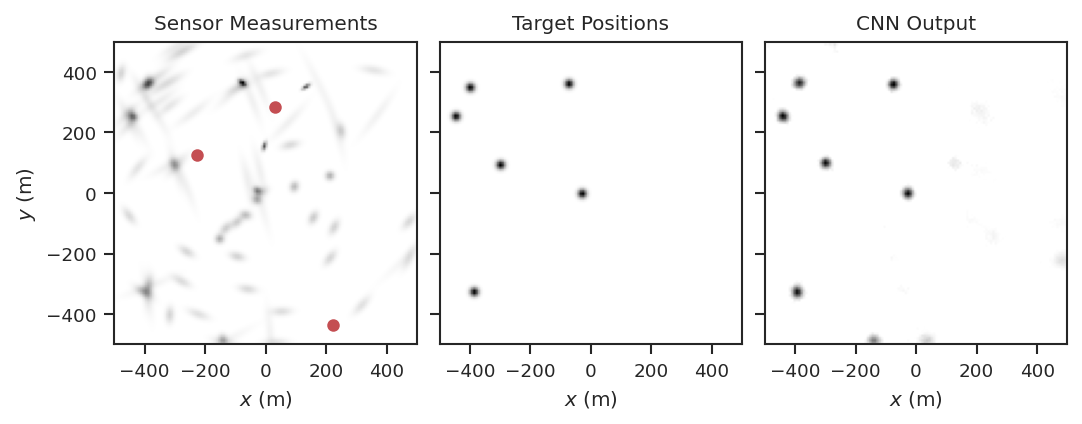

In [73]:
step_idx = -1

with sns.axes_style("ticks"):
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.1, 3.5))
    imshow_kwargs = dict(
        extent=extent,
        origin="lower",
        cmap="gray_r",
    )

    axs[0].set_title("Sensor Measurements")
    axs[0].imshow(stacked[step_idx].sensor_images[filt_idx].cpu(), **imshow_kwargs)
    axs[0].plot(
        *stacked[step_idx].info[filt_idx]["sensor_positions"].T, "ro", markersize=5
    )
    axs[0].set_xlim(xmin=extent[0], xmax=extent[1])
    axs[0].set_ylim(ymin=extent[2], ymax=extent[3])

    axs[1].set_title("Target Positions")
    axs[1].imshow(stacked[step_idx].target_images[filt_idx].cpu(), **imshow_kwargs)

    axs[2].set_title("CNN Output")
    axs[2].imshow(pred_img[step_idx][filt_idx], **imshow_kwargs)

    axs[0].set_ylabel("$y$ (m)")
    for ax in axs:
        ax.set_xlabel("$x$ (m)")

    plt.savefig("../figures/images.pdf", bbox_inches="tight")
    plt.show()


In [66]:
mean_energy = np.mean(
    [pos_img[1].cpu().clamp(min=0).sum(dim=[-1, -2]) for _, pos_img, _ in stacked]
)
mean_cardinality = np.mean(
    [len(info["target_positions"]) for _, _, infos in stacked for info in infos]
)
mean_energy, mean_cardinality


(7.734038, 7.6575)

In [67]:
card_true = np.array([len(d[2][filt_idx]["target_positions"]) for d in stacked])
card_cnn = np.array([len(p) for p in predictions_cnn])
card_img = pred_img.sum(axis=(-1, -2))


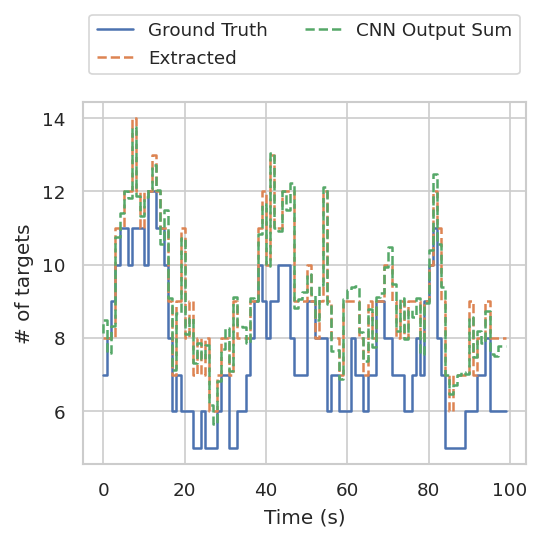

In [68]:
# plot cardinality
plt.step(np.arange(n), card_true, label="Ground Truth")
plt.step(np.arange(n), card_cnn, label="Extracted", linestyle="dashed")
plt.step(np.arange(n), card_img, label="CNN Output Sum", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("# of targets")
# legend to the right of axis
plt.legend(bbox_to_anchor=(0.5, 1.05), loc="lower center", ncol=2)
plt.savefig("../figures/cardinality.pdf")
plt.show()


Mean OSPA: 243.80m ± 64.51m
Mean OSPA (Position): 124.29m ± 65.92m
Mean OSPA (Cardinality): 191.50m ± 84.45m


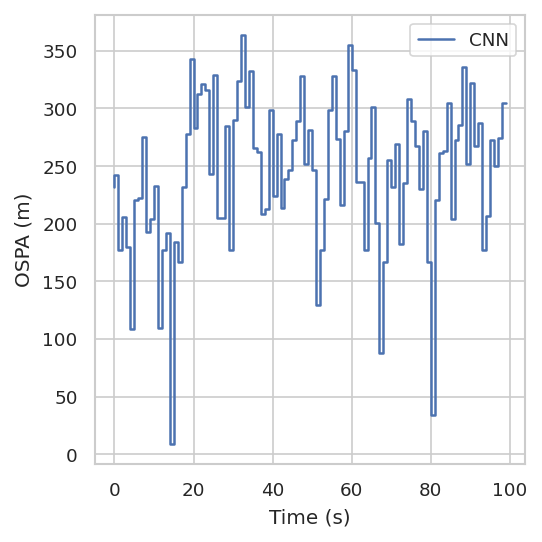

In [69]:
ospa_cnn = []
ospa_cnn_components = []
for idx in range(n):
    sensor_img, target_img, info = stacked[idx]
    target_positions = info[-1]["target_positions"]
    ospa_cnn += [compute_ospa(target_positions, predictions_cnn[idx], 500, p=2)]
    ospa_cnn_components += [
        compute_ospa_components(target_positions, predictions_cnn[idx], 500, p=2)
    ]

ospa_cnn_components = np.array(ospa_cnn_components)
print(f"Mean OSPA: {np.mean(ospa_cnn):.2f}m \u00B1 {np.std(ospa_cnn):.2f}m")
print(
    f"Mean OSPA (Position): {np.mean(ospa_cnn_components[:,0]):.2f}m \u00B1 {np.std(ospa_cnn_components[:,0]):.2f}m"
)
print(
    f"Mean OSPA (Cardinality): {np.mean(ospa_cnn_components[:,1]):.2f}m \u00B1 {np.std(ospa_cnn_components[:,1]):.2f}m"
)

plt.figure()
plt.step(np.arange(n), ospa_cnn, label="CNN")
# plt.step(np.arange(n), ospa_cnn_components[:,0], label="CNN (Position)")
# plt.step(np.arange(n), ospa_cnn_components[:,1], label="CNN (Cardinality)")
plt.ylabel("OSPA (m)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../figures/ospa.pdf")


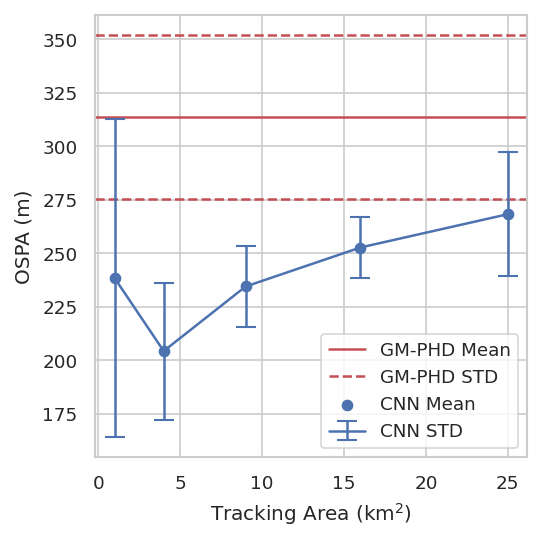

In [70]:
# plot CNN performance generalization
df = pd.DataFrame(
    dict(
        width=[1, 2, 3, 4, 5],
        cnn_mean=[238.45, 204.34, 234.48, 252.68, 268.24],
        cnn_std=[74.40, 31.97, 19.04, 14.05, 29.04],
    )
)
phd_std = 76.58
phd_mean = 313.78

plt.figure()
plt.axhline(phd_mean, color="r", label="GM-PHD Mean")
plt.axhline(phd_mean + phd_std / 2, color="r", linestyle="--", label="GM-PHD STD")
plt.axhline(phd_mean - phd_std / 2, color="r", linestyle="--")
plt.scatter(df.width**2, df.cnn_mean, label="CNN Mean")
plt.errorbar(df.width**2, df.cnn_mean, yerr=df.cnn_std, capsize=5, label="CNN STD")
plt.legend()
plt.xlabel("Tracking Area (km$^2$)")
plt.ylabel("OSPA (m)")
plt.savefig("../figures/transfer.pdf")
